# Basic RBM gammapy analysis for VERITAS data

Versions: gammapy (1.0), V2DL3 (0.5)

Uses [rbm.py](../scripts/rbm.py) and [data_products.py](../scripts/data_products.py) for 2D RBM and 1D spectral/LC analyses, respectively.

Optionally, [makeBackground.py](../background_from_bkg/makeBackground/makeBackground.py) can be used to generate bkg headers here. bkg generation and attachment can also be done in [the prepare_dataset notebook](prepare_dataset.ipynb). 

**If you already have DL3 files with bkg headers, you can skip step 2.**

In [1]:
import sys
import numpy as np
import yaml
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import os

import astropy.units as u

from gammapy_tools.templates import get_config
from gammapy_tools.make_background import *
import gammapy_tools.make_background as bkg
from gammapy_tools.analysis import make_spectrum_RE, get_flux_lc, rbm_analysis, rbm_plots, write_validation_info

from gammapy.data import DataStore

import warnings
warnings.filterwarnings("ignore")

## 1. Set up bkg and analysis configuration

***Note: bkg $\equiv$ radial acceptance!***

This should be a "full" config file containing background generation information as well as analysis (RBM + 1D spectra and lightcurve) information. 

An example config file is [example_config.yaml](example_config.yaml).

Even if you have generated bkg headers elsewhere, the `'io'`, `'exclusion'`, `'analysis_selection'`, and `'run_selection'` parameters are re-used in the scripts needed to run this notebook.

### Here are some details for setting up your config file:

- **`io`** defines your directory structure - **this should be changed for every user to match their directory setup**:
    - **`runlist`**: a typical EventDisplay runlist with 1 run number per line. This is "optional" but is helpful if you're using a large input directory (e.g., a directory containing all pre-processed data) and only want to analyze certain runs.
    - **`in_dir`**: the directory containing your DL3 files (either pre-processed data or from V2DL3). These are the files we will be appending bkg headers to (if they already have bkg headers, the headers will be overwritten).
    - **`out_dir`**: the directory containing the final DL3 files with bkg headers appended. This is the directory referenced for RBM analysis.
    - **`results_dir`**: the directory where plots and high-level output will be saved.
    - **`from_run`**: whether or not bkgs should be generated in a run-wise fashion or with similar data. For bkg generation in this notebook, this should be set to False. If you want run-wise backgrounds, [prepare_dataset.ipynb](prepare_dataset.ipynb) should be used instead of step 2 of this notebook. 
    - **`from_runlist`**: whether or not the bkg generatioin and analysis should only use selected runs defined above in `runlist` or if all runs in `in_dir` should be analyzed
    
- **`binning`** defines the energy and camera coordinate binning of the bkg files - **this generally should not be changed except for experimenting with different bkg techniques**
    - **`e_min`**: minimum energy bin [TeV]
    - **`e_max`**: maximum energy bin [TeV]
    - **`e_bins`**: number of energy bins
    - **`off_min`**: minimum offset from camera center [deg]
    - **`off_max`**: maximum offset from camera center [deg]
    - **`off_bins`**: number of offset bins
    
- **`config`** is used for multithreading - not used in this notebook **not used here, no need to change**

- **`exclusion`** defines the exclusion regions masked out in bkg files - **the target source of each observation, gammacat, and HAWC sources are excluded automatically, so there is generally no need to provide `exclude_source_name` or `exclude_regions`**:
    - **`star_cat`**: the catalog of stars to search for exclusion regions (this is by default the Hipparcos catalog used by ED). This generally should not be changed but the user can substitute for another catalog if they wish.
    - **`exclude_source_name`**: exclude a source with a given, SIMBAD-resolved name
    - **`exclude_regions`**: exclude source(s) given source coordinates in an array of tuples (one tuple per source) `[ ("RA deg", "DEC deg", "radius_to_exclude deg"), ("287.10 deg", "6.39 deg", "0.5 deg"), (), ...]`
    
- **`background_selection`** defines the criteria that runs should fulfill to be included in bkg data. Ideally these should match run criteria as precisely as possible, but can be adjusted iteratively such that there are at least 10h of background data for every 30 minute target data run (i.e., each run you are appending bkgs to). Default values given here are similar to [Ruo's extended source validation memo](https://veritas.sao.arizona.edu/GammaWiki/images/9/99/Mimic_data_method_memo_v2.pdf) but slightly loosened to find matching runs in the same season as the target data.
    - **`el_diff`**: maximum 1/sin(elevation) difference
    - **`az_diff`**: maximum azimuth difference [deg]
    - **`n_tels`**: minimum number of telescopes
    - **`time_max`**: maximum difference in time between target run and bkg runs (not used if using `same_szn = True`
    - **`smooth`**: whther or not to smooth bkg files by the PSF in camera space (default should be true)
    - **`same_szn`**: whether bkg files should come from the same season as target runs (true is recommended)
- **`run_selection`**:
    - **`runlist`**: not used in this notebook   
    - **`source_name`**: source name for output - should be a string
    - **`source_ra`**: source RA (ICRS) [deg]
    - **`source_dec`**: source DEC (ICRS) [deg]
    - **`offset_max`**: maximum offset of events from camera center (default = 1.5)
    - **`n_tel`**: minimum number of telescopes required for every run
    - **`el_min`**: minimum run elevation

- **`spectrum`** information for creating the source spectrum (this is a gammapy 1D reflected regions analysis)
    - **`e_min`**: minimum energy bin
    - **`e_max`**: maximum energy bin
    - **`nbins`**: number of energy bins
    - **`type`** : spectral model (string): "PL" = power law, "LP" = log parabola, "EXPPL" = exponential cutoff power law
    - **`params`** : normalization and spectral index in an array: e.g., [3.48e-11,2.4]

- **`lightcurve`** information for LC analysis (1D reflected regions). No need to specify bin size if you're just running an integrated flux analysis (see section 3ii)
    -**`bin_size_min`**: temporal bin size [minutes]

- **`sky_map`**: 
    - **`map_deg`**: map size [deg] (square map => height = length) default = 2.5
    - **`bin_sz`**: sky map bin size [deg] (ED default = 0.01)
    - **`exclusion_regions`**: regions to exclude from significance calculations, formatted as lists of `[[SkyCoord, radius], [SkyCoord, radius], ...]` where SkyCoord is defined [here](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html).
  - **`theta`**: square root of theta^2
  - **`on_exclusion_region`**: source exclusion region [deg] (0.35 for point sources is ED default)
  - **`ring_rin`**: inner ring radius [deg]
  - **`ring_width`**: ring width [deg]
  - **`truncate`**: if true, truncate the sky map colourbar at $\pm 5 \sigma$, otherwise, show full significance range
  - **`aeff_max_percent`**': percentage of the maximal effective area to be used as lower energy threshold for method (see [here](https://docs.gammapy.org/dev/api/gammapy.makers.SafeMaskMaker.html)) (default is 0.1)
  - **`min_star_brightness`**: dimmest B-band apparent magnitude to exclude stars in the FoV from significance calculations (ED default is 8)
  
- **`results_file`**: yaml file to save results to (this will save within `[io][results_dir]`)
- **`plot_names`**: prefix of plot names (this will save within `[io][results_dir]`)

In [6]:
with open('/raid/romulus/swong/gammapy-background-analysis/examples/segue.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [7]:
config

{'io': {'runlist': '/raid/romulus/swong/ED490/Eventdisplay_AnalysisScripts_VTS/scripts/segue.txt',
  'search_datastore': '/raid/reedbuck/dl3/ed/dl3_fullenclosure_moderate2tel/',
  'in_dir': '/raid/romulus/swong/mydl3/seguenew/',
  'out_dir': '/raid/romulus/swong/mydl3/seguenew/bkgs/',
  'results_dir': '/raid/romulus/swong/mydl3/seguenew/bkgs/',
  'from_run': False,
  'from_runlist': True},
 'binning': {'e_min': 0.25,
  'e_max': 100,
  'e_bins': 20,
  'off_min': 0,
  'off_max': 2,
  'off_bins': 5},
 'config': {'njobs': 5},
 'exclusion': {'star_cat': './Hipparcos_MAG8_1997.dat',
  'exclude_source_name': None,
  'exclude_regions': None},
 'background_selection': {'nsb_diff': 1.5,
  'el_diff': 1.5,
  'az_diff': 45,
  'n_tels': 4,
  'time_max': 180,
  'smooth': True,
  'smooth_sigma': 1,
  'same_szn': True,
  'time_request': 20,
  'KL_DIV': True},
 'run_selection': {'source_name': 'Segue 1',
  'pos_from_DL3': True,
  'offset_max': 3.5,
  'n_tel': 4,
  'el_min': 30},
 'spectrum': {'e_min': 0

# 2. Background generation

The following lines generate bkg headers for runs matching the conditions defined in `config['background_selction']`. Run-wise background generation is currently not supported but this can be found in `examples/prepare_dataset`. 

**If you wish to skip bkg generation, make sure your DL3 files with attached bkg headers are located in `config['io']['out_dir']` and skip to step 3**

## Load in our data runs

Our DL3 files are contained in the config file in `config['io']['in_dir']`- let's load those in and look at our runlist

Alternatively, if you have preprocessed anasum files on disk or only want to use selected runs in the directory, you can set `config['io']['in_dir']` to your datastore and set `config['io']['use_runlist'] = True` as well as providing a runlist (same as ED runlist; one run number per line) in `config['io']['runlist']`, which tells gammapy which runs to use.

In [8]:
data_store = DataStore.from_dir(config["io"]["in_dir"])

if config['io']['from_runlist']:
    obs_ids = np.genfromtxt(config['io']['runlist'],dtype=int,unpack=True)
    
else:
    obs_ids = data_store.obs_ids
print(obs_ids)

[77021 77022 77069 77162 77209 77284 77320 80167 80189 80190 80288 80289
 80335 80515 80517 80518 80538 80539 80659 80660 80661 80686 80687 80688
 80708 80709 80710 80711 80734 80735 80952 80953 80977 80978 81436 81437]


## Find and attach bkgs to the data runs

gammapy uses bkg files (called backgrounds) in the same way that VERITAS analyses use radial acceptances (i.e., bkg $\equiv$ radial acceptance). These normalize the counts in the ring background according to changes in camera acceptance dropping off with radial distance. 

We want to match these bkg files as closely as possible in observing conditions and time to our actual data runs, using parameters defined in our config file.

Radial acceptance is also energy dependent, so we want to define some energy bins at which to generate bkg files. We also want to bin in the X-Y camera plane.

By default, bkgs are also smoothed by a Gaussian kernel with a 1-pixel width in the camera plane

The `get_background_for_run` function takes as input a tuple with (obs_id,config) and takes the input run matching the observation ID from `config['io']['in_dir']` and outputs a DL3 file with an appended bkg to `config['io']['out_dir']`.

This prints out the number of background run hours that are found for each data run. If this is < 10, consider loosening the observing parameters in `config['background_selection']`

In [9]:
for obs in tqdm(obs_ids):
    print(obs)
    get_background_for_run((obs,config))

  0%|          | 0/36 [00:00<?, ?it/s]

77021


KeyError: "Extension 'BACKGROUND' not found."

In [22]:
from astropy.io import fits
import gammapy

hdul = fits.open(config["io"]["in_dir"] + "77021.fits.gz")

gammapy.irf.Background2D.from_hdulist(hdul)

KeyError: "Extension 'BACKGROUND' not found."

## Write index files for the new DL3 directory

From now on, `config['io']['out_dir']` is the data directory containing DL3 files ready for data analysis (bkgs are appended).

In [54]:
write_index_files(config)

## Peek at data to make sure everything worked

All plots should load, in particular make sure the background rate histogram is filled, since this is the only part of the DL3 file we've changed in this notebook.

INFO:gammapy.data.data_store:Observations selected: 36 out of 36.


77021


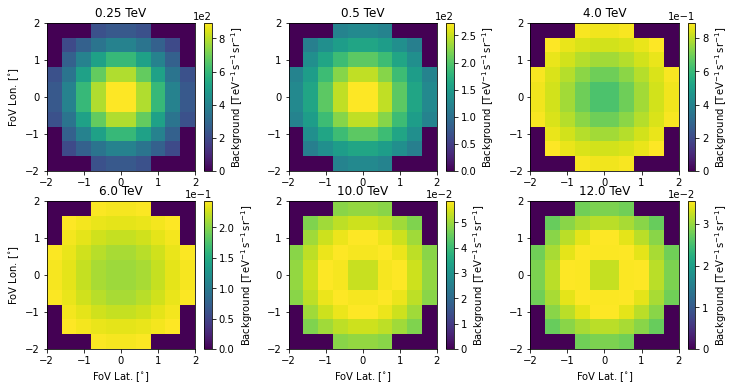

77022


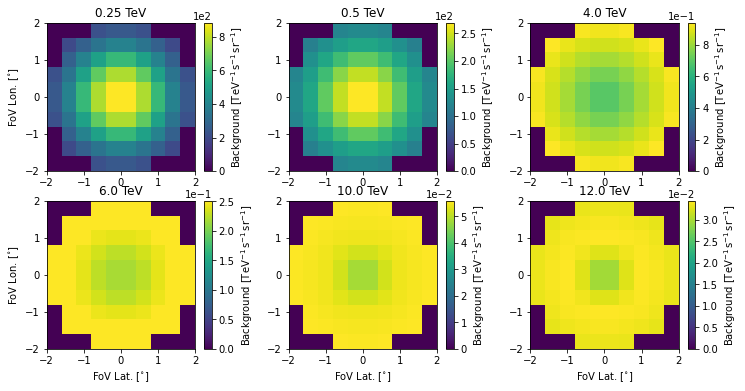

77069


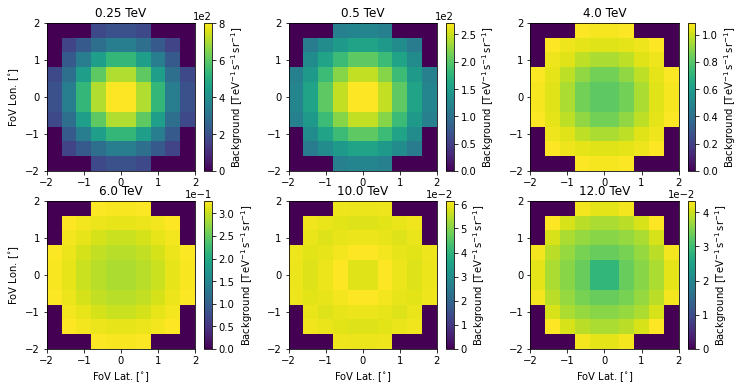

77162


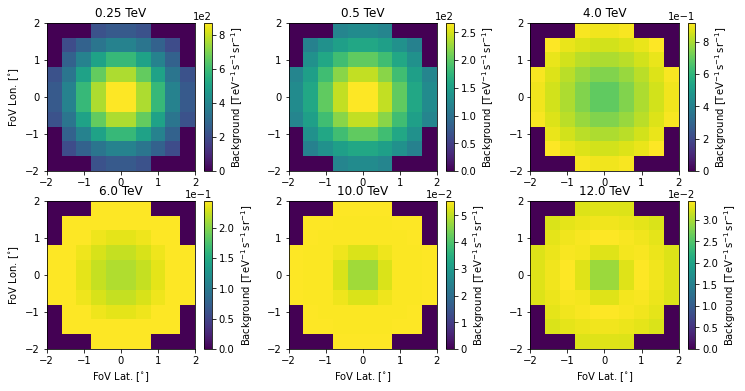

77209


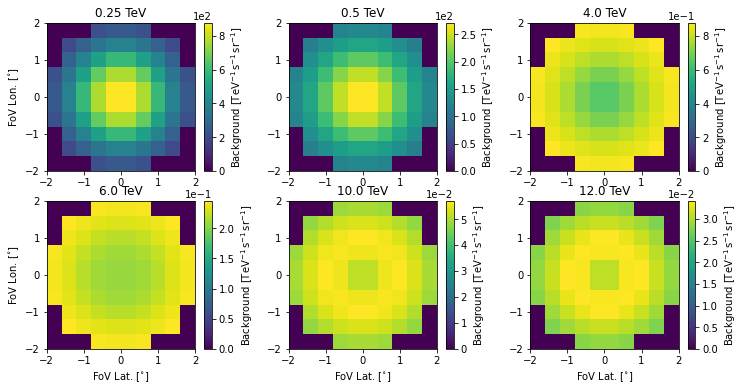

77284


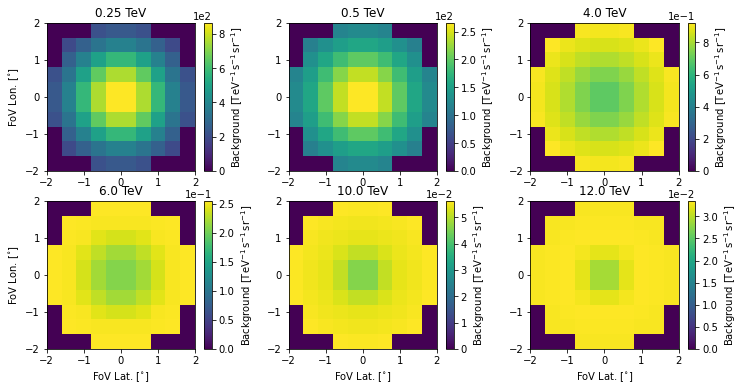

77320


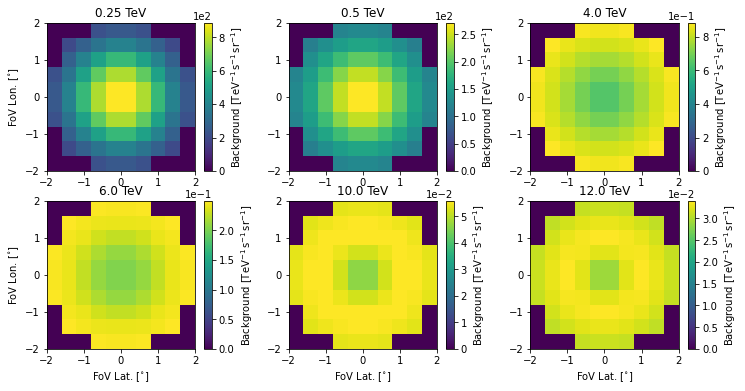

80167


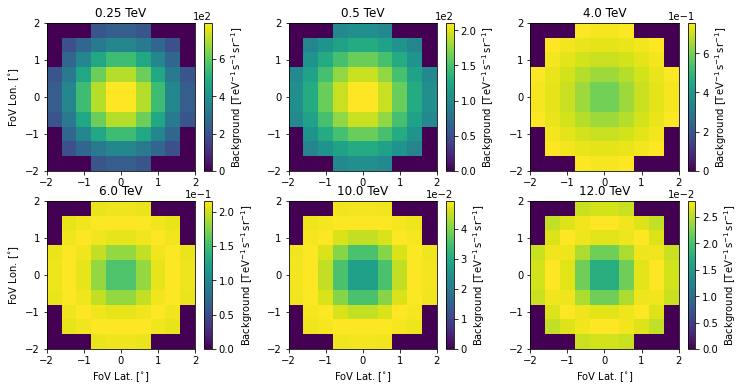

80189


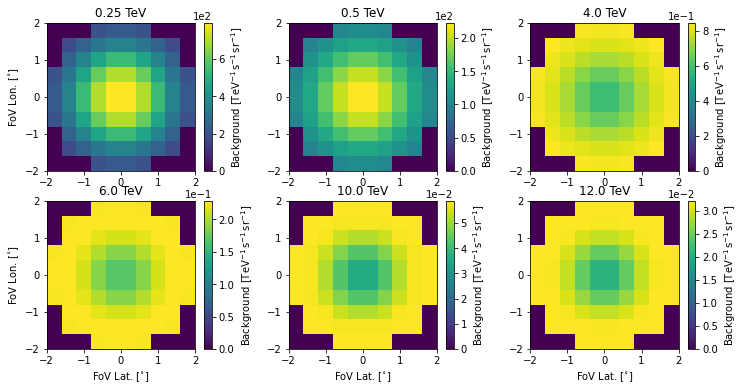

80190


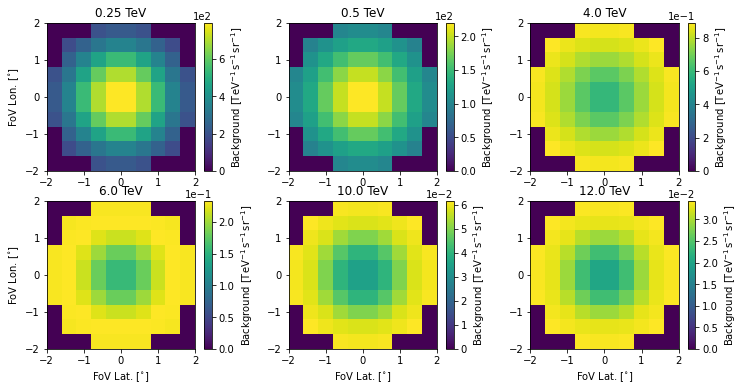

80288


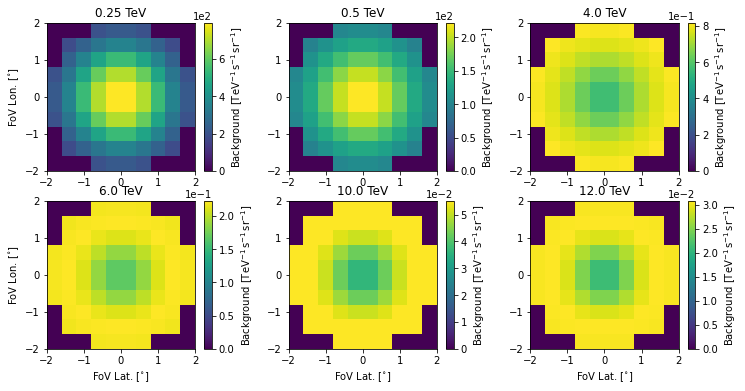

80289


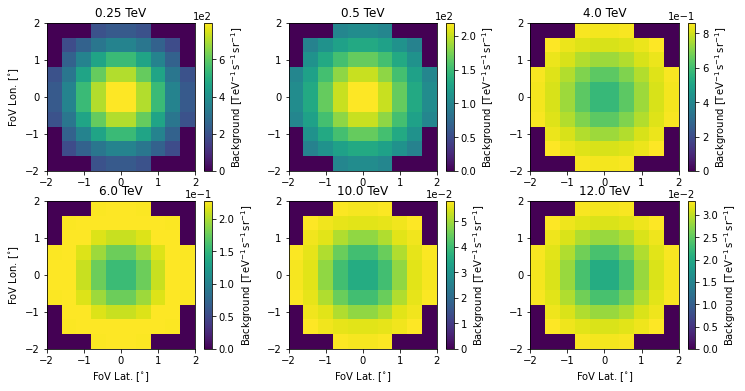

80335


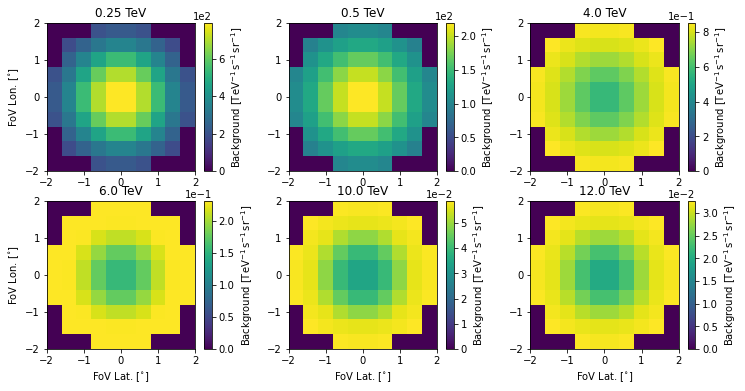

80515


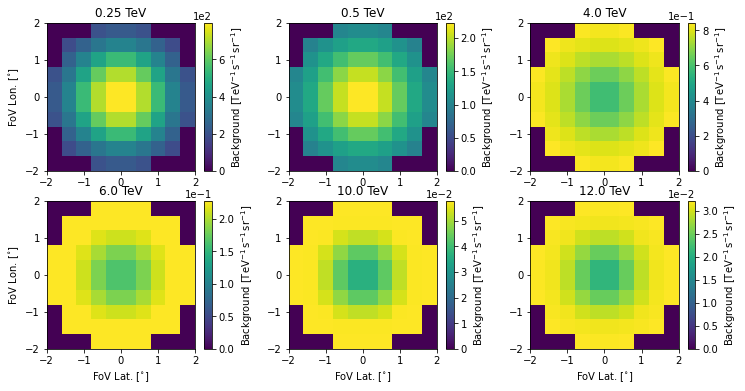

80517


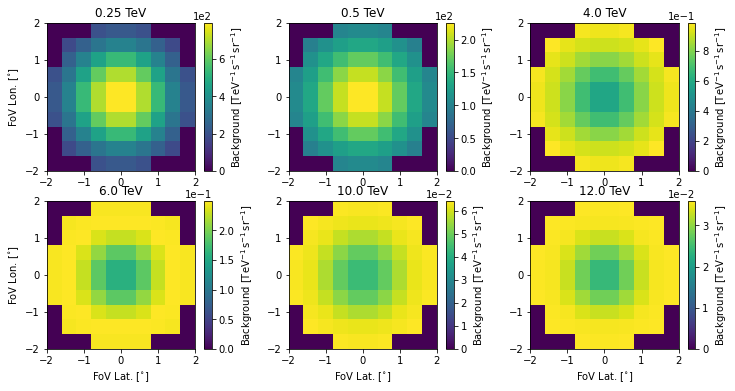

80518


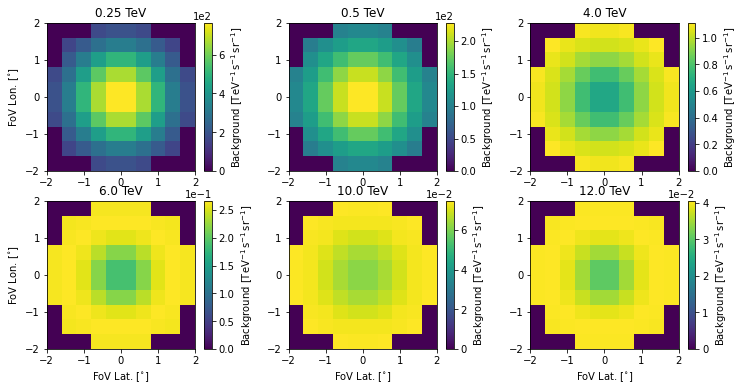

80538


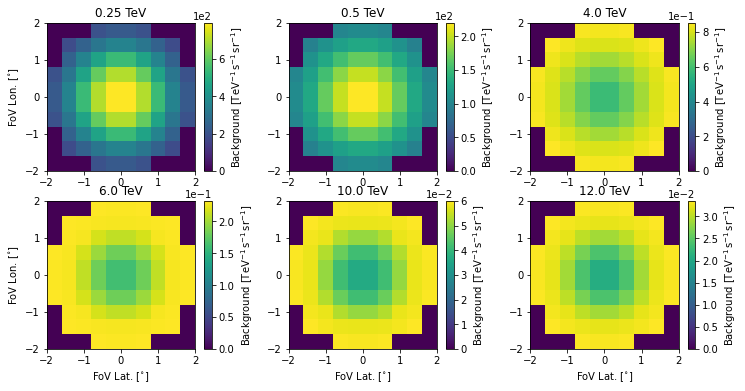

80539


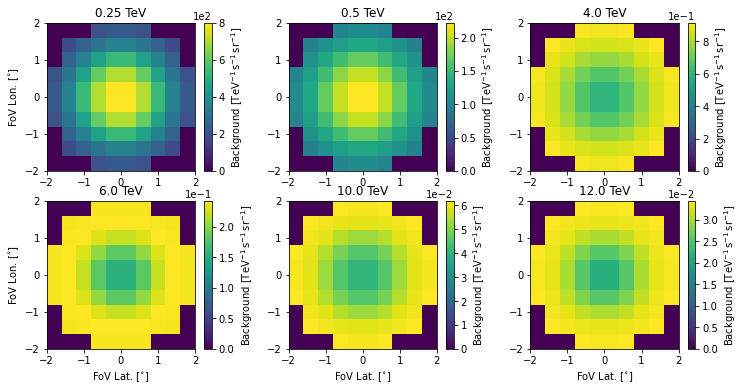

80659


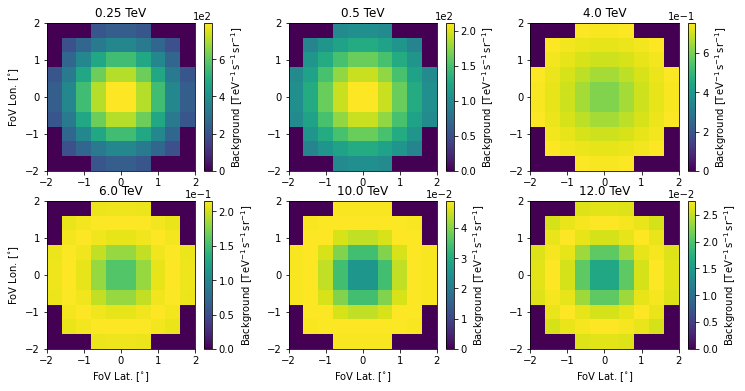

80660


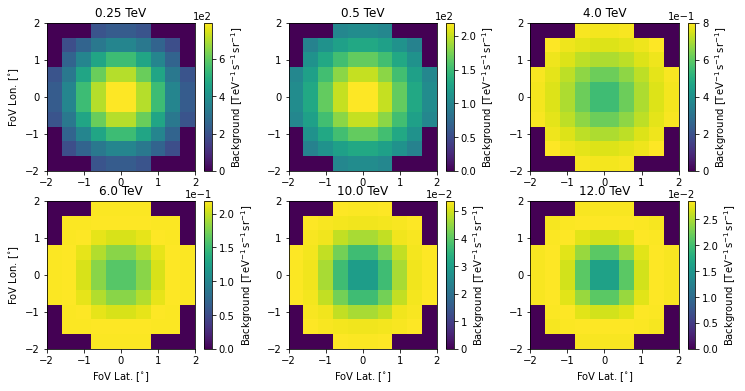

80661


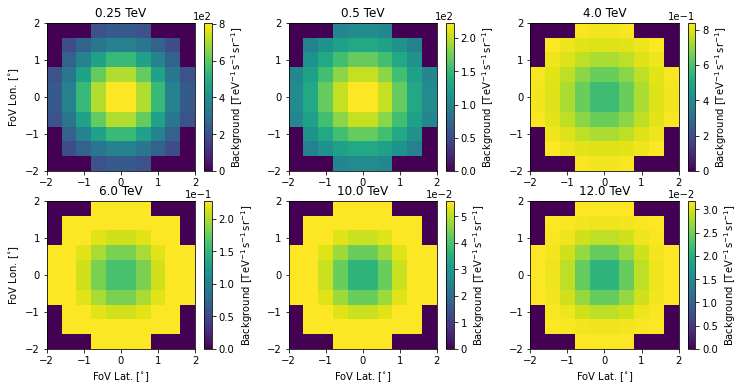

80686


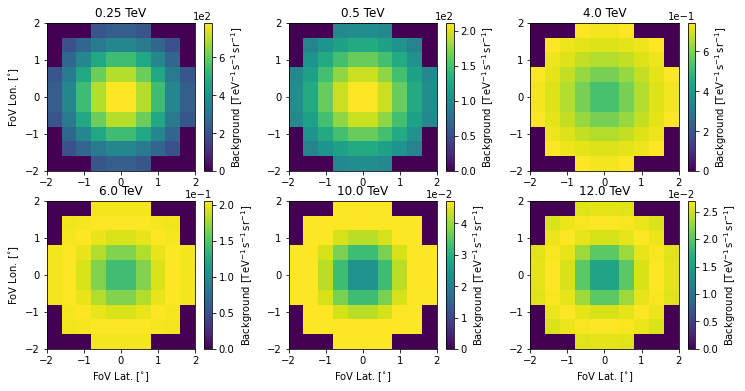

80687


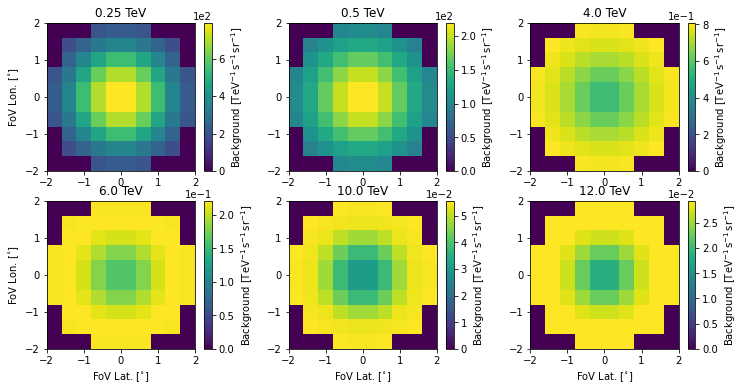

80688


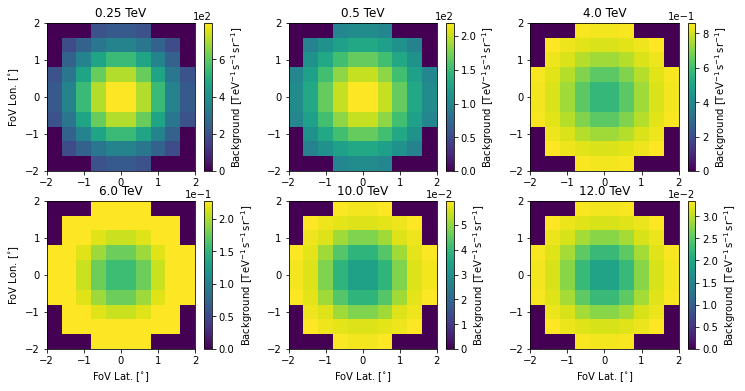

80708


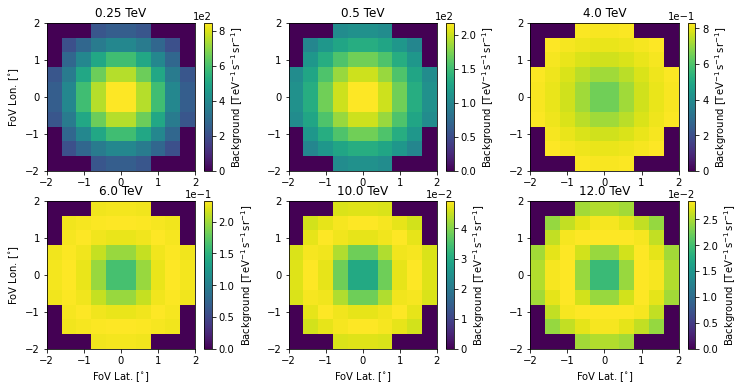

80709


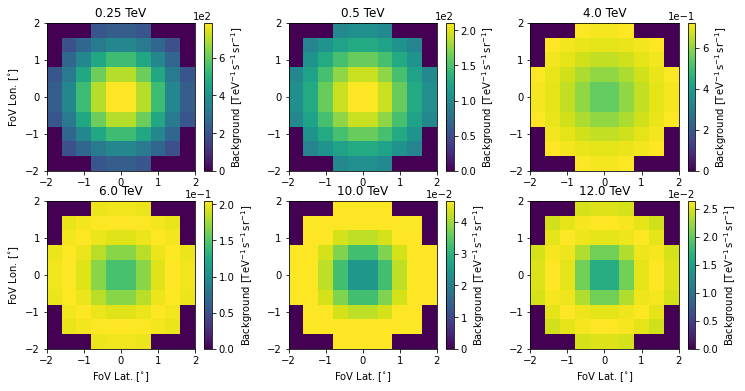

80710


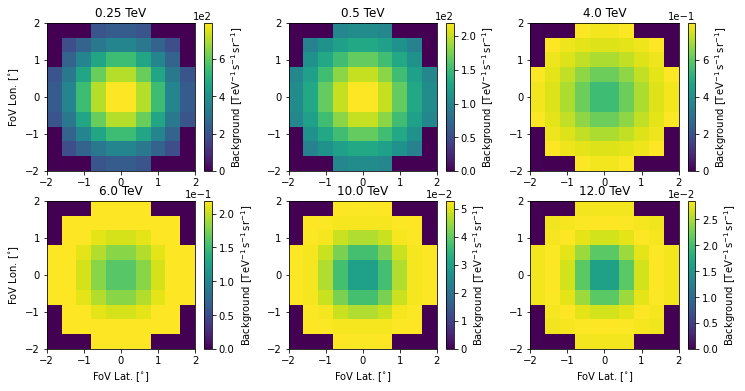

80711


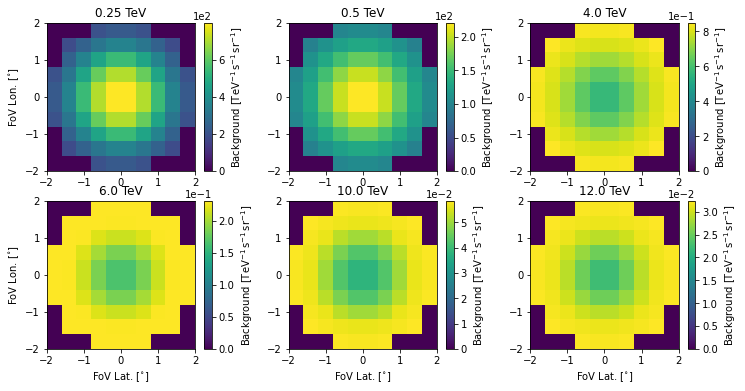

80734


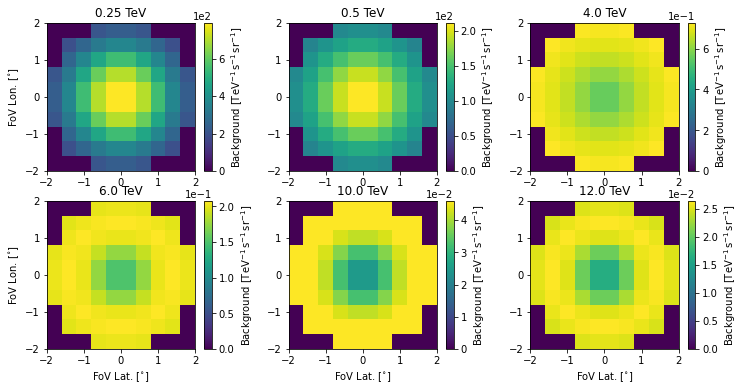

80735


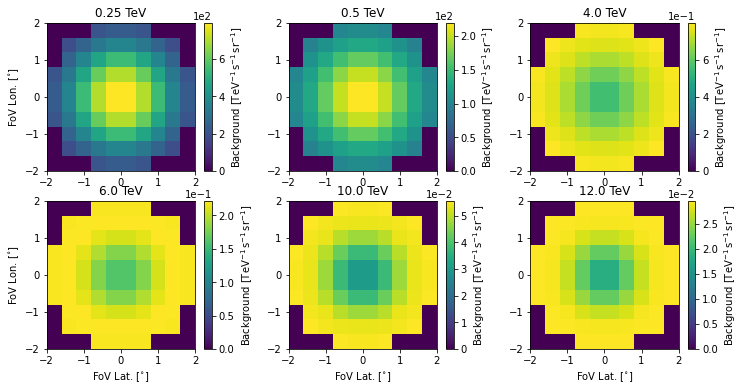

80952


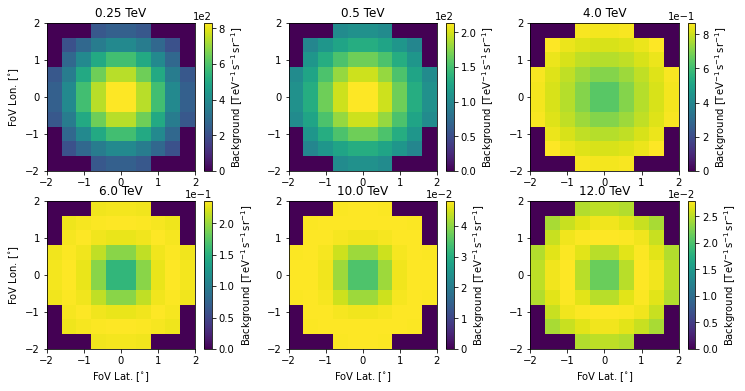

80953


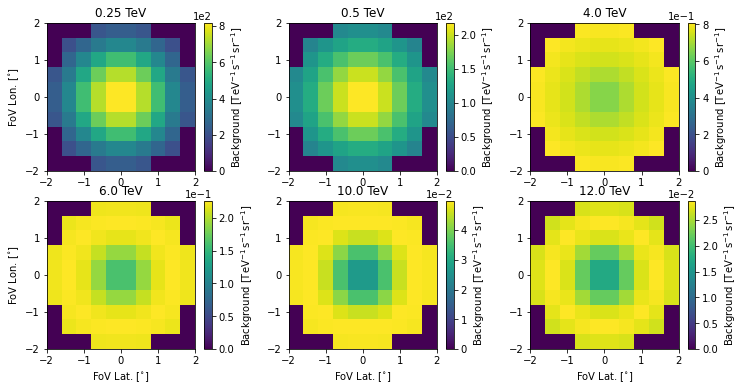

80977


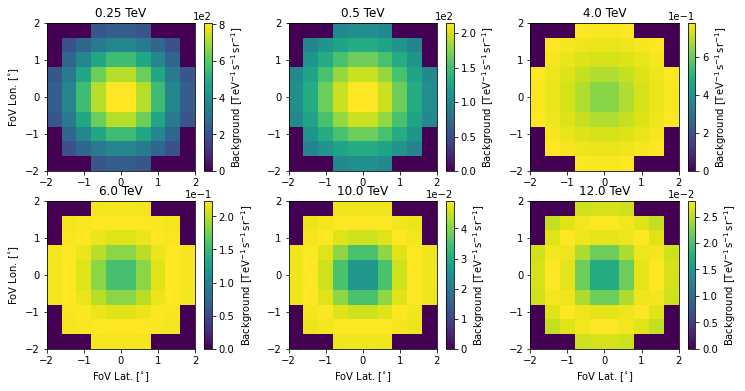

80978


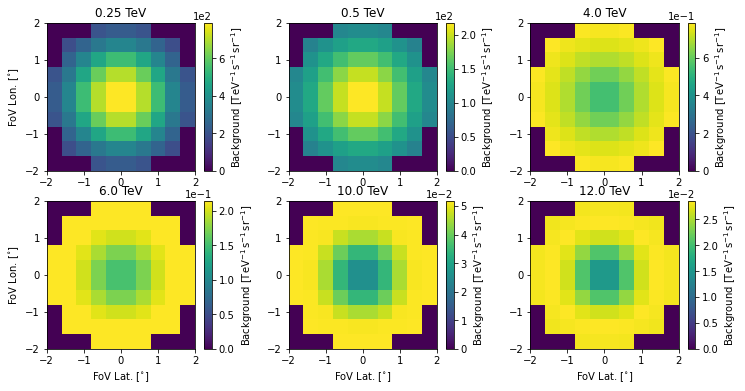

81436


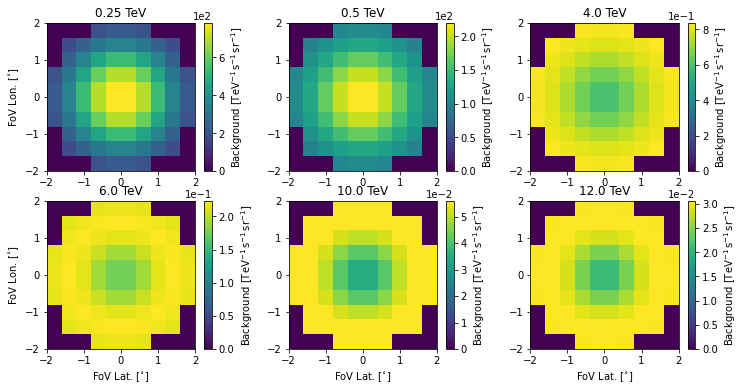

81437


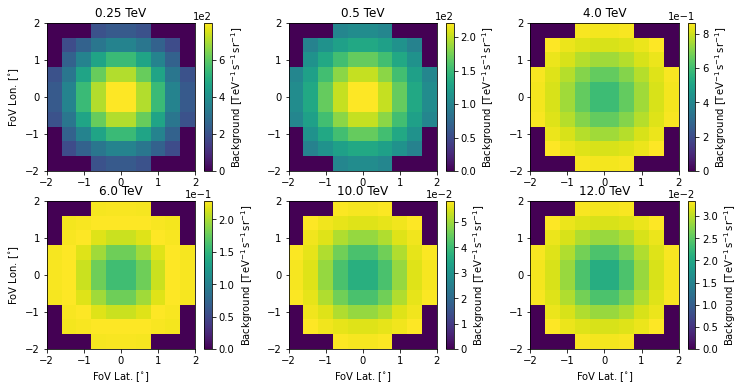

In [55]:
from gammapy.data import DataStore

my_data = DataStore.from_dir(config["io"]["out_dir"])
my_observations = my_data.get_observations()

for obs in my_observations:
    print(obs.obs_id)
    #obs.peek()
    obs.bkg.plot_at_energy([0.25 * u.TeV,0.5*u.TeV,4*u.TeV,6*u.TeV,10*u.TeV,12*u.TeV])
    plt.show()

# 3. Analysis

This performs a 1D (energy only) reflected regions analysis to get the spectrum and light curve (which gives an integrated flux value for all observations). Sky maps and significances are determined with a 2D (energy + acceptance) ring background analysis.

## i) Spectral analysis

Spectral analysis parameters are read in from the `spectrum` section of the config file

Performs a spectral analysis using reflected regions. The "ON" region is defined by `config['sky_map']['on_exclusion_region']` and should be $\sqrt{\theta^2}$ for point sources

If a spectrum type is not provided, this script will do a power law fit by default.

The first plot produced shows the exclusion regions used, and the second is an $E^2 \frac{dn}{de}$ spectrum.

In [56]:
spectral_points, spectral_model, cumulative_time, cumulative_sig = make_spectrum_RE(config,plot=False)

INFO:gammapy.data.data_store:Observations selected: 36 out of 36.


<Figure size 432x288 with 0 Axes>

$\frac{dn}{de}$ spectrum to match ED output (for validation purposes)

In [57]:
spectral_points.plot(sed_type='dnde')

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

Error in callback <function _draw_all_if_interactive at 0x7f9297e31940> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

## ii) Flux/LC analysis

Outputs the integral flux in units of $\textrm{cm}^2 \textrm{s}^{-1}$ (default) or a lightcurve

`get_flux_lc(config,"runwise")` will output a runwise lightcurve

`get_flux_lc(config,"custom")` will output a custom binned lightcurve. The binning is defined in `config['lightcurve']['bin_size_min']` as the time per bin in minutes. 

In [58]:
flux = get_flux_lc(config,'flux')

INFO:gammapy.data.data_store:Observations selected: 36 out of 36.


## iii) RBM analysis

Calculates counts, excess, significance, etc. using RBM normalized by the background files appended to each run.

Smaller skymap binning results in much longer runtimes. A binning of 0.01 deg is recommended to match ED, but fast analyses may be done with larger binning (gammapy default is 0.02 deg).

In [59]:
counts, excess, background, alpha, sigma, excess_map, exposure, significance_map, exclusion_mask = rbm_analysis(config)

INFO:gammapy.data.data_store:Observations selected: 36 out of 36.


## Plot results

Makes RBM maps (significance & excess) and RBM significance distribution. 1D cumulative significance from spectral analysis is also plotted.

These plots are saved with the prefix: `config['plot_names']`

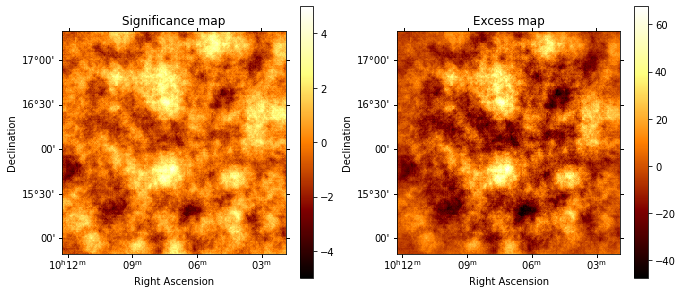

Fit results: mu = -0.01, std = 0.98


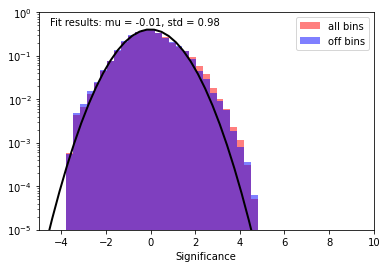

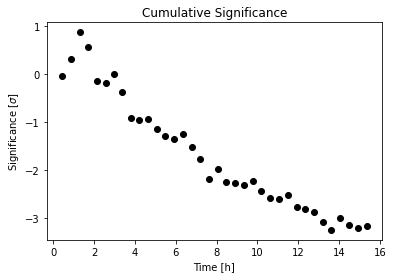

ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [60]:
rbm_plots(config,spectral_points,excess_map, significance_map,cumulative_sig,cumulative_time,exclusion_mask)

# 4. Analysis output

Write the analysis output (currently formatted for inputting into the gammapy validation page: https://veritas.sao.arizona.edu/wiki/Gammapy_Validation).

This is saved in yaml format to `config['results_file']`.

**You should also upload your config file after validating a source for reproducibility!**

In [ ]:
write_validation_info(config,spectral_model,flux,counts,background,alpha,sigma,exposure)